# Creating Dataframe

In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)
import seaborn as sns
sns.set()

In [2]:
X_names, y = get_data(target_names=all_6, nr_signals=np.inf, only_names=True)

100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


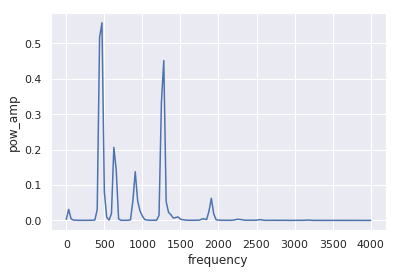

In [35]:
rdm = np.random.randint(0,280000)

data = read_simple([X_names[rdm]])[0].T
data_psd = power_spectral_density(data)
sns.lineplot(data=data_psd, x='frequency', y='pow_amp')

In [36]:
data_psd.shape

(129, 2)

In [223]:
from scipy import signal as sg
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize

crop=False; bandpass=False,
fs=F_S; scaling='density'; window='hanning'; nperseg=256; noverlap=128+64; nfft=None

rdm = np.random.randint(0,280000)
data = read_simple([X_names[rdm]])[0].T

sig = data
if bandpass: # Buttersworth bandpass filter
    sig = butter_bandpass_filter(data=data.flatten(), lowcut=L_CUTOFF, highcut=H_CUTOFF, fs=F_S, order=B_ORDER)
if crop: # Perform cropping
    sig = crop_signal(sig, window=300, intens_threshold=0.0004, offset=200)
    if sig is None or sig.empty or sig.shape[0] < 256:
        logging.warning('Signal is None, empty or too small after cropping!')
        raise ValueError('SSS')

# Calculating PSD
freqs, p_amps = sg.welch(data, fs=fs, scaling=scaling, window=window, nfft=nfft, nperseg=nperseg, noverlap=noverlap)
# Normalization of PSD amplitudes
p_amps = normalize(p_amps.reshape(-1,1), norm='l2', axis=0).reshape(-1,)#10*np.log10(p_amps.reshape(-1,1)).reshape(-1,)#
psd = pd.concat([pd.Series(freqs), pd.Series(p_amps)], axis=1)
# Cropping up to 2500 Hz (mosquitos don't have more)
# psd = psd.iloc[:crop_hz,:]
psd.columns = ['frequency','pow_amp']

plt.close("all")
plt.figure(figsize=(12,6))
sns.lineplot(data=psd, x='frequency', y='pow_amp')
plt.ylim(-0.01,1.)

FigureCanvasNbAgg()

(-0.01, 1.0)

In [122]:
plt.close()

In [95]:
%matplotlib widget
plt.figure(figsize=(12,6))
sns.lineplot(data=psd, x='frequency', y='pow_amp')

FigureCanvasNbAgg()

In [123]:
plt.close()

In [21]:
def process_parallel(path):
    data, _ = read_simple([path])
    fname = path.split('/')[-1][:-4]
    processed = process_signal(fname=fname, data=data)
    df = pd.DataFrame.from_dict(processed, orient='index').reset_index()
    df['names'] = path
    return df
## RUN ONCE - takes some time
cpus = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cpus)
result_list = []
result_list.append(pool.map(process_parallel, X_names))
df = pd.concat(result_list[0], axis=0, sort=False)
# df.to_csv('./data/mosquitos.csv', sep=';')

# Reading and Exporting Dataframe

In [75]:
def read_insect_df():
    df = pd.read_csv('./data/mosquitos.csv', delimiter=';')
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.rename(columns={'index': 'fname'}, inplace=True)
    df['pathlen'] = df.names.apply(lambda x: len(x.split('/')))
    df['fnamelen'] = df.fname.apply(lambda x: len(x.split('_')))
    df['temp'] = df.fname.apply(lambda x: x.split('_')[-3] if len(x.split('_')) > 5 else np.nan)
    df['humd'] = df.fname.apply(lambda x: x.split('_')[-1] if len(x.split('_')) > 5 else np.nan)
#     df['label'] = y
#     df.label = df.label.apply(lambda x: all_6[x])
    return df

In [76]:
df = read_insect_df()

In [78]:
# df.to_csv('./data/mosquitos.csv', sep=';')

## Analyzing dataframe

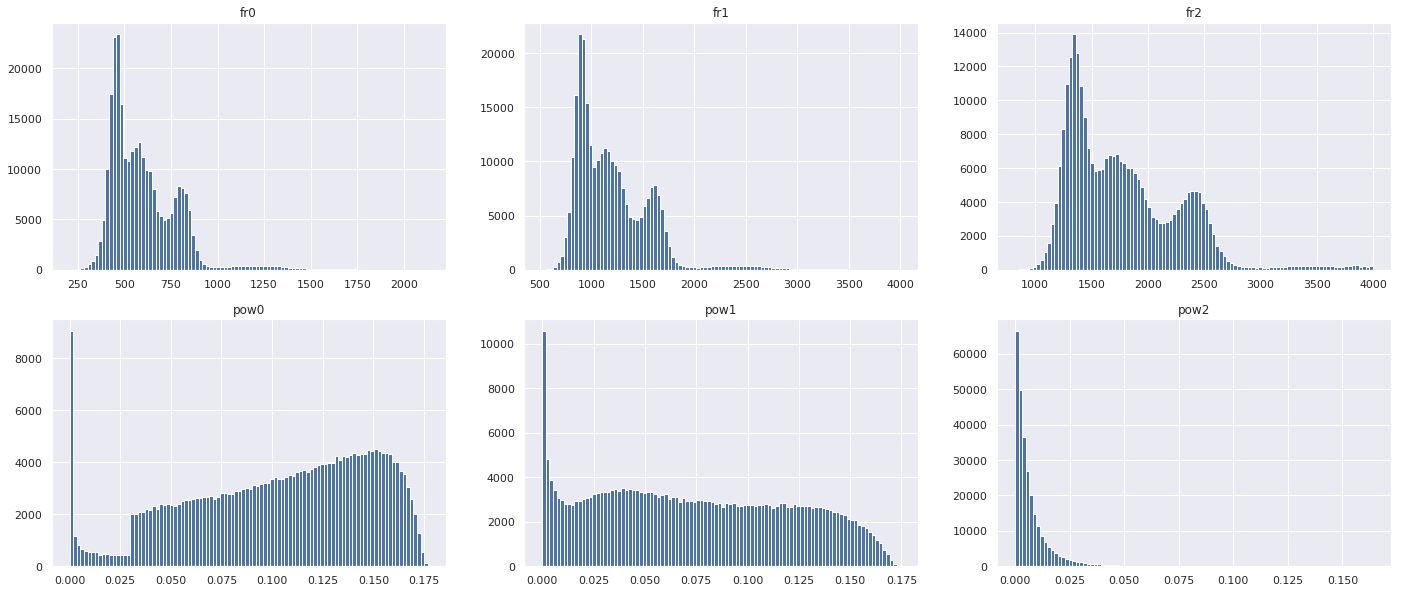

In [79]:
import matplotlib.pyplot as plt
nr_bins = 100
plt.figure(figsize=(24,10))
plt.subplot(2,3,1); plt.title('fr0'); df['fr0'].hist(bins=nr_bins)
plt.subplot(2,3,2); plt.title('fr1'); df['fr1'].hist(bins=nr_bins)
plt.subplot(2,3,3); plt.title('fr2'); df['fr2'].hist(bins=nr_bins)
plt.subplot(2,3,4); plt.title('pow0'); df['pow0'].hist(bins=nr_bins)
plt.subplot(2,3,5); plt.title('pow1'); df['pow1'].hist(bins=nr_bins)
plt.subplot(2,3,6); plt.title('pow2'); df['pow2'].hist(bins=nr_bins)
plt.show()

## After cleaning

In [80]:
df = df[(df.damping_0 > 0.005) & (df.damping_1 > 0.005) & (df.damping_2 > 0.005)]
df = df[(df.pow0 > 0.025)      & (df.pow1 > 0.005)      & (df.pow2 > 0.0005)]
df = df[(df.fr0 < 900.)        & (df.fr1 < 1800.)       & (df.fr2 < 3600.)]

df.shape

(199293, 16)

In [81]:
df.to_csv('./data/mosquitos_clean.csv', sep=';')

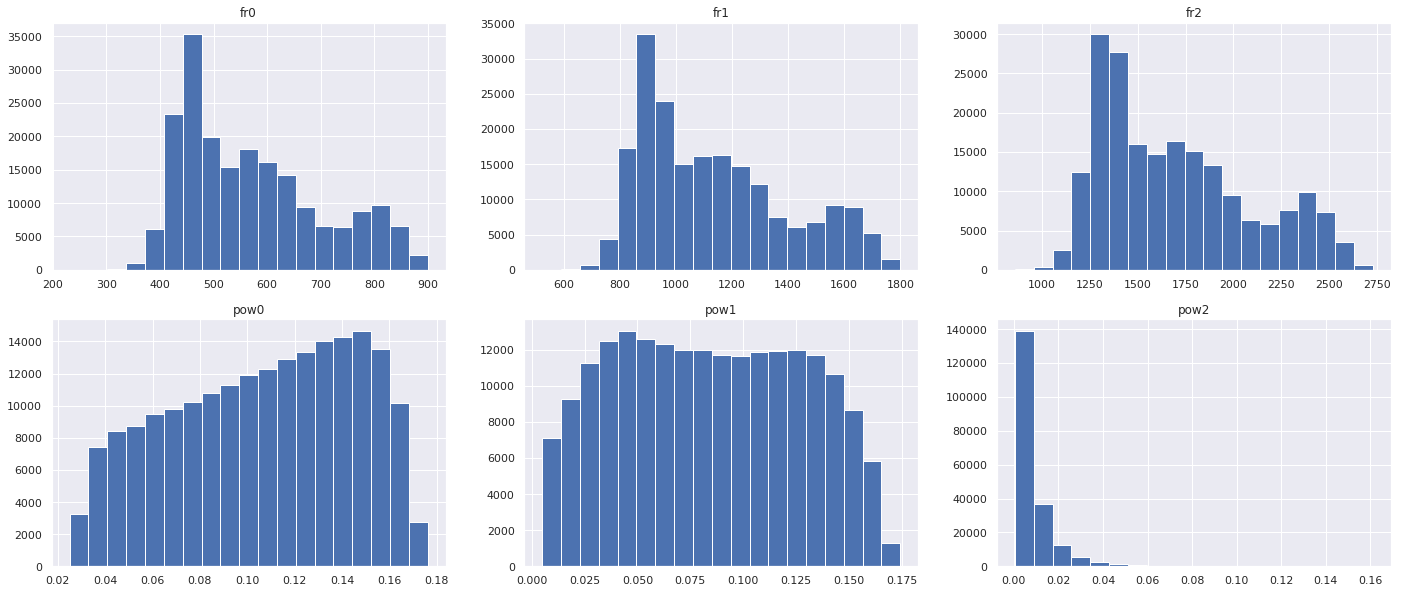

In [82]:
import matplotlib.pyplot as plt
nr_bins = 19
plt.figure(figsize=(24,10))
plt.subplot(2,3,1); plt.title('fr0'); df['fr0'].hist(bins=nr_bins)
plt.subplot(2,3,2); plt.title('fr1'); df['fr1'].hist(bins=nr_bins)
plt.subplot(2,3,3); plt.title('fr2'); df['fr2'].hist(bins=nr_bins)
plt.subplot(2,3,4); plt.title('pow0'); df['pow0'].hist(bins=nr_bins)
plt.subplot(2,3,5); plt.title('pow1'); df['pow1'].hist(bins=nr_bins)
plt.subplot(2,3,6); plt.title('pow2'); df['pow2'].hist(bins=nr_bins)
plt.show()

In [83]:
df.drop(['fname', 'names', 'pathlen', 'fnamelen'], axis=1).sample(10)

,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,temp,humd,label
215221,0.031542,0.162618,0.008408,477.539062,959.960938,1445.312500,0.054192,0.024924,0.017905,NaN,NaN,C. quinquefasciatus
82620,0.081477,0.116265,0.004814,612.304688,1260.742188,1824.218750,0.055821,0.026723,0.023287,NaN,NaN,Ae. aegypti
131685,0.119481,0.022234,0.001044,811.523438,1621.093750,2429.687500,0.016847,0.024096,0.010852,NaN,NaN,An. gambiae
82223,0.122675,0.088590,0.019834,545.898438,1092.773438,1632.812500,0.045617,0.031278,0.009868,NaN,NaN,Ae. aegypti
117457,0.126784,0.099425,0.002183,600.585938,1205.078125,1750.976562,0.043089,0.020665,0.010318,NaN,NaN,An. gambiae
223777,0.071495,0.122032,0.006832,435.546875,864.257812,1290.039062,0.067265,0.039548,0.021953,NaN,NaN,C. quinquefasciatus
159419,0.070573,0.142440,0.013212,497.070312,960.937500,1443.359375,0.055992,0.026423,0.019283,25.9,72.6,An. arabiensis
236404,0.072613,0.043045,0.009310,412.109375,787.109375,1173.828125,0.048578,0.019231,0.032862,NaN,NaN,C. quinquefasciatus
237715,0.091367,0.095390,0.003282,443.359375,902.343750,1317.382812,0.064978,0.047078,0.014826,NaN,NaN,C. quinquefasciatus
217185,0.091175,0.122562,0.017688,458.984375,904.296875,1357.421875,0.053191,0.032937,0.020863,NaN,NaN,C. quinquefasciatus


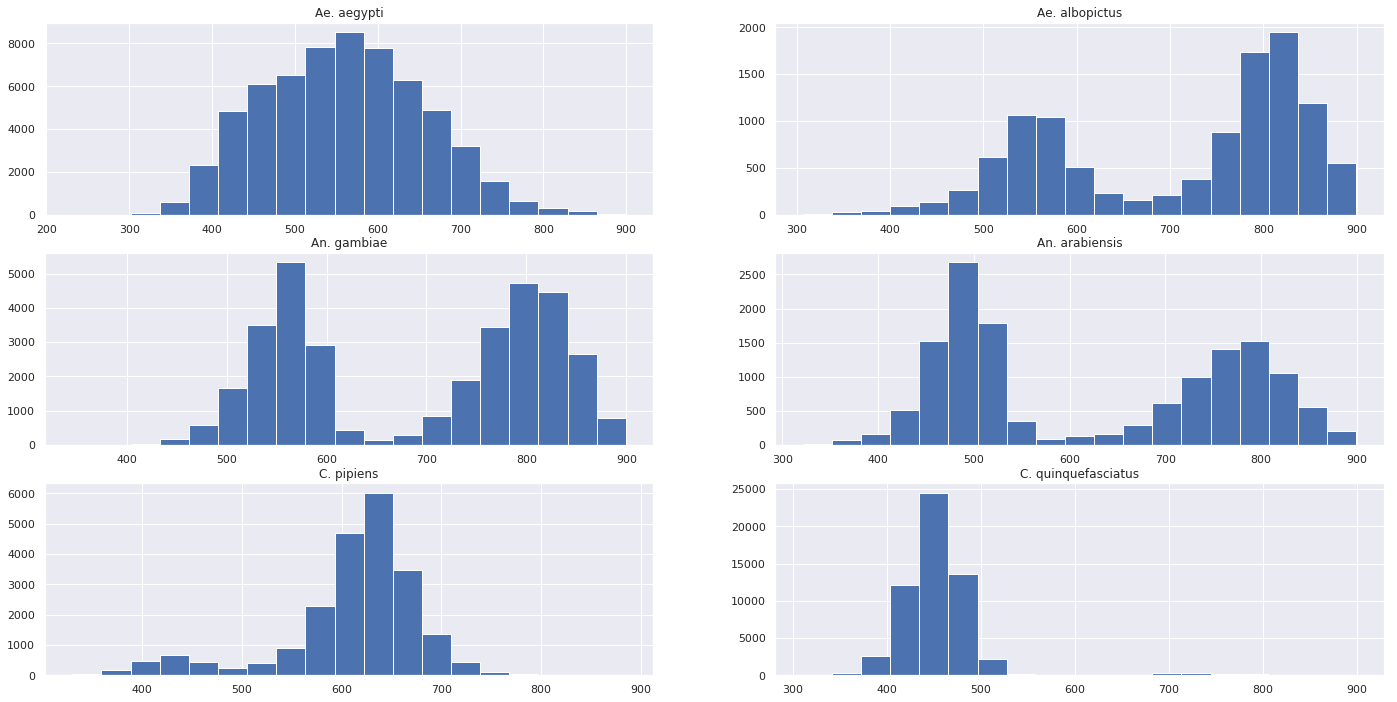

In [84]:
label = 'label'
mosqlist = df[label].unique().tolist()
plt.figure(figsize=(24,12))
for i in range(len(mosqlist)):
    plt.subplot(3,2,i+1);
    plt.title(mosqlist[i]);
    df[df[label]==mosqlist[i]].fr0.hist(bins=19)
    #plt.ylim(0,8500)

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/mosquitos.csv', delimiter=';')
#plt.rcParams.update({'font.size': 50})


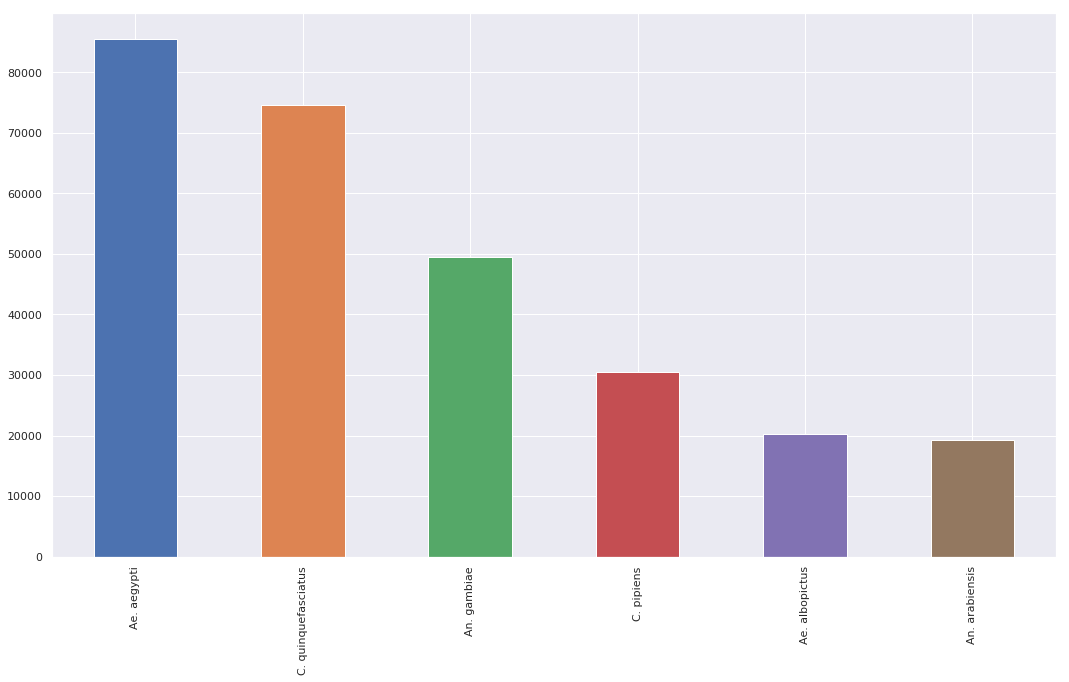

In [95]:
plt.figure(figsize=(18,10))
df.label.value_counts().plot(kind='bar')

In [96]:
df.drop(['fname', 'names', 'pathlen', 'fnamelen'], axis=1, inplace=True)

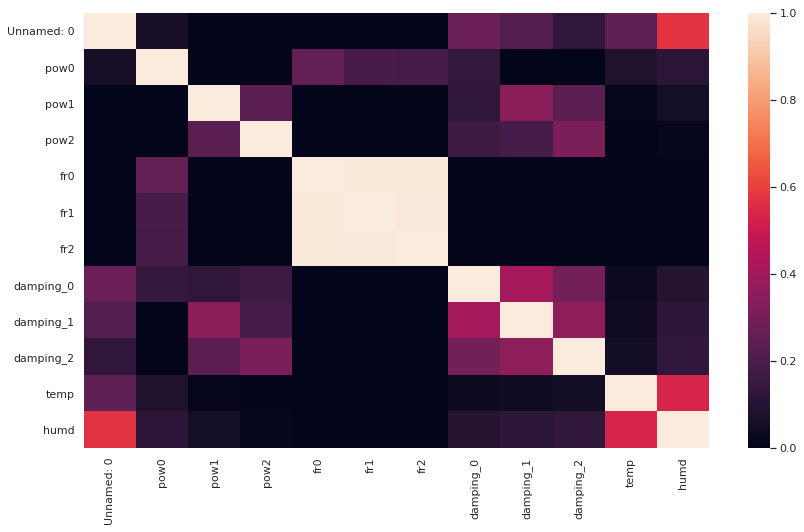

In [97]:
plt.figure(figsize=(14,8))
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin=0,
        vmax=1)

In [89]:
def read_insect_df():
    df = pd.read_csv('./data/mosquitos_clean.csv', delimiter=';')
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.rename(columns={'index': 'fname'}, inplace=True)
    df['pathlen'] = df.names.apply(lambda x: len(x.split('/')))
    df['fnamelen'] = df.fname.apply(lambda x: len(x.split('_')))
    df['temp'] = df.fname.apply(lambda x: x.split('_')[-3] if len(x.split('_')) > 5 else np.nan)
    df['humd'] = df.fname.apply(lambda x: x.split('_')[-1] if len(x.split('_')) > 5 else np.nan)
    #df['label'] = y
    #df.label = df.label.apply(lambda x: all_6[x])
    return df
X_names, y = get_data(target_names=all_6, nr_signals=np.inf, only_names=True)
df = read_insect_df()

100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


In [90]:
df[df.pow1 > df.pow0].label.value_counts()

Ae. aegypti            32332
C. quinquefasciatus    21878
C. pipiens              8108
An. gambiae             7493
Ae. albopictus          3726
An. arabiensis          3136
Name: label, dtype: int64

In [91]:
df.label.value_counts()

Ae. aegypti            61789
C. quinquefasciatus    56561
An. gambiae            33917
C. pipiens             21772
An. arabiensis         14140
Ae. albopictus         11114
Name: label, dtype: int64

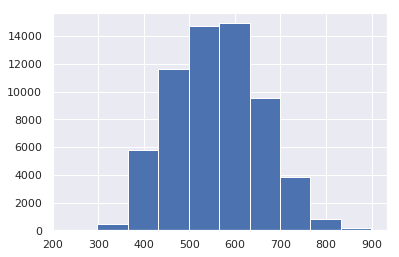

In [92]:
df[df.label=='Ae. aegypti'].fr0.hist()